In [1]:
# Import necessary libraries
from appgeopy import *
from my_packages import *

In [11]:
def run_LR(input_series):
    """
    return: linear trend, coefficients, full-time indexes
    """
    series_index = input_series.index
    fulltime_index = datetime_handle.get_fulltime(series_index)
    
    series_index_numeric = (series_index-series_index[0]).days.to_numpy()
    fulltime_numeric = (fulltime_index-fulltime_index[0]).days.to_numpy()
    
    linear_trend, coeffs = analysis.get_polynomial_trend(x=series_index_numeric, y=input_series.to_numpy(), order=1, x_estimate=fulltime_numeric)
    return [linear_trend, coeffs, fulltime_index]

In [3]:
# Load HDF5 file containing compaction data
dataset_path = r"D:\1000_SCRIPTS\003_Project002\20241016_MLCW_to_HDF5\20241105_MLCW_CRFP_v6.h5"
data, metadata = gwatertools.open_HDF5(dataset_path)

stations = list(data.keys())
for station in stations:
    print(station, end="\t")

ANHE	ANNAN	BEICHEN	BUDAI_XIN	CANLIN	CHENGDA	CHENGDAXIN	DAFU	DAZHUANG	DAZHUANG1	DINGLIAO	DONGGUANG	DONGSHI	ERLUN	FANGLIAO	FENGAN	FENGRONG	GUANGFU	GUOLU	HAIFENG	HONGLUN	HUNAN	HUWEI	JIADONG	JIANYANG	JIAXING	JINHU	JINHU_XIN	JIUZHUANG	KECUO	LINBIAN	LONGYAN	LUNFENG_XIN	NANGUANG	NANKE	NANXING	NEILIAO	QIAOYI	SHULIN	TANQIFENXIAO	TUKU	WANGLIAO	XIAYING	XIGANG	XINGHUA	XINJIE	XINPI	XINSHENG	XINXING	XIUTAN	XIZHOU	XUEJIA	YANTIAN	YILI	YIWU	YUANCHANG	ZHENGMIN	ZHENNAN	ZHUTANG	

<AxesSubplot: >

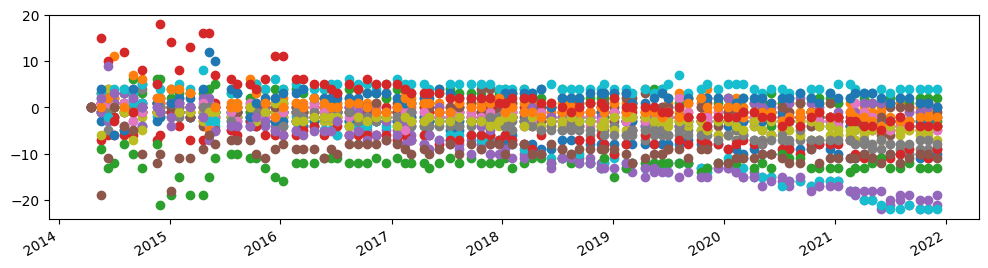

In [4]:
station_name = "GUANGFU"

time_arr = list(map(lambda x: x.decode(), data[station_name]["date"]))  # Decode byte strings
time_arr = pd.to_datetime(time_arr)  # Convert to pandas datetime format

# Extract depth values corresponding to measurements
depth_arr = data[station_name]["depth"]

# Retrieve compaction data (measured relative to base reference)
compact_ref2base = data[station_name]["values"]["ref2base"]

# Convert data into a pandas DataFrame and preprocess it
compact_df = pd.DataFrame(data=compact_ref2base, columns=time_arr)  # Create DataFrame
compact_df = compact_df.loc[:, "2014":"2022"]  # Select data within the time range
compact_df = compact_df * 1000  # Convert meters to millimeters
compact_byDepth = compact_df.diff(-1)  # Compute year-over-year compaction differences
compact_byDepth.iloc[-1, :] = compact_df.iloc[-1, :]
compact_byDepth = compact_byDepth.sub(compact_byDepth.iloc[:, 0], axis=0)

compact_byDepth.T.plot(marker="o", linestyle=" ", legend=False, figsize=(12, 3))

<AxesSubplot: xlabel='Datetime'>

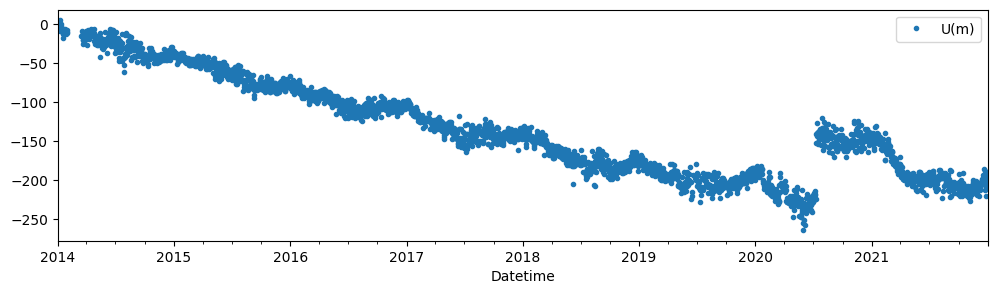

In [5]:
gps_fpath = r"E:\SUBSIDENCE_PROJECT_DATA\GPS_2024_HsuYaru\2__Processed\A__Fulltime\GFES.csv"
gps_df = pd.read_csv(gps_fpath, parse_dates=[0], index_col=[0], usecols=[0, 3])
gps_df = gps_df.loc["2014":"2021"]
gps_df = gps_df * 1000
gps_df = gps_df.sub(gps_df.iloc[0],axis=1)
gps_df.plot(figsize=(12, 3), marker="o", linestyle=" ", ms=3)

In [6]:
select_year = 2014
gps_byPeriod = gps_df.loc[f"{select_year}-5":f"{select_year+1}-5"]

gps_linear_trend, gps_coeffs, gps_fulltime_idx = run_LR(gps_byPeriod["U(m)"])
gps_velocity = gps_coeffs[-1]*365.25 # convert to mm/year
gps_velocity

-31.18177761827923

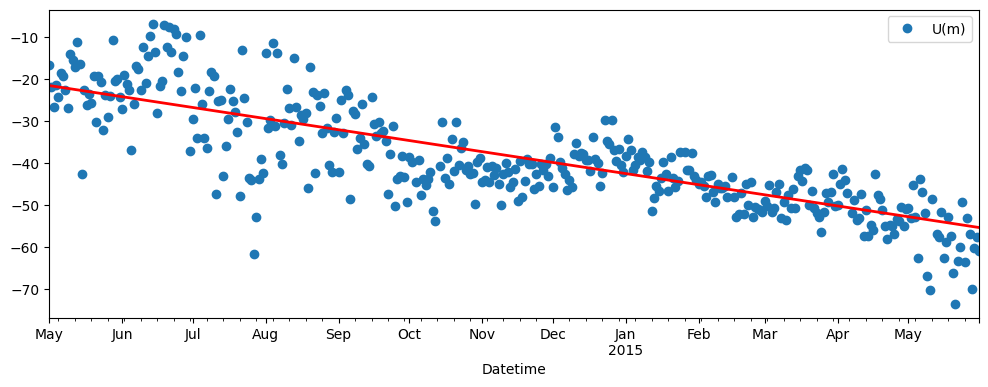

In [7]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
gps_byPeriod.plot(ax=ax, marker='o', linestyle=' ')
ax.plot(gps_fulltime_idx, gps_linear_trend, color='r', lw=2)

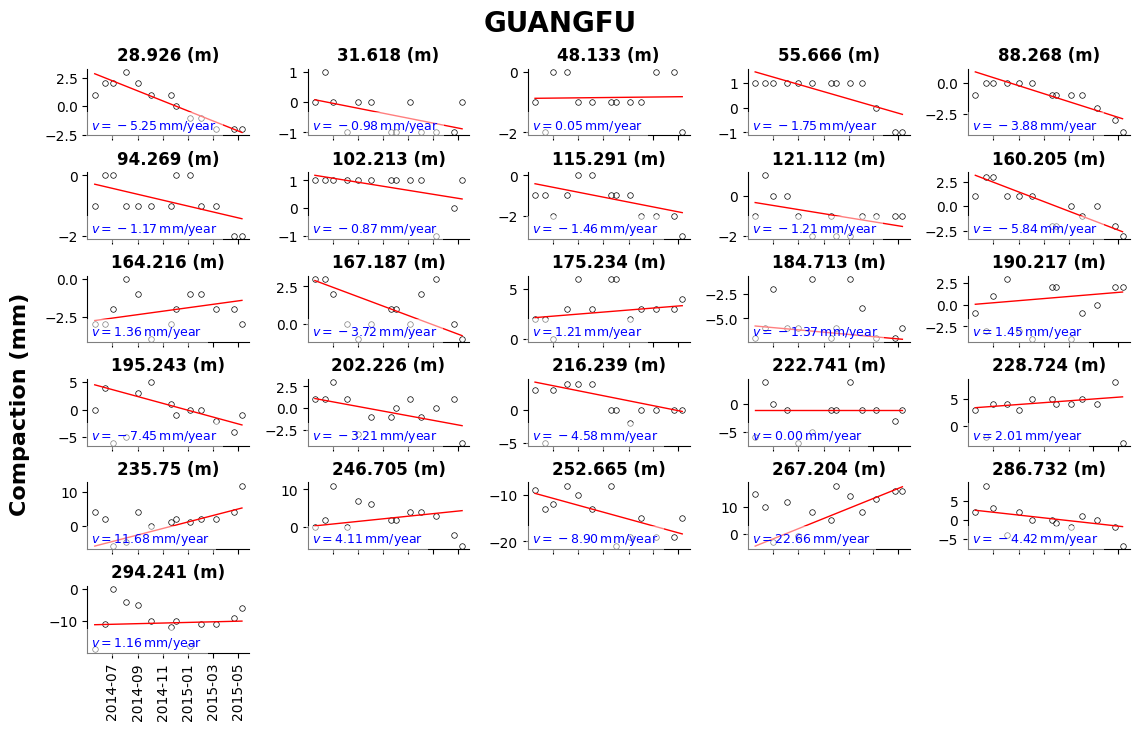

In [12]:
compact_byDepth_byPeriod = compact_byDepth.loc[:, f"{select_year}-5":f"{select_year+1}-5"]

# Determine subplot grid size
ncols = 5
nrows = int(len(compact_byDepth_byPeriod) / ncols) + (len(compact_byDepth_byPeriod) % ncols > 0)  # Auto-calculate rows

# Create figure and subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11.7, 8.3), sharex=True)
axs = axs.flatten()

# Set plot axis limits
bot_lim = np.floor(compact_byDepth_byPeriod.min().min())
top_lim = np.ceil(compact_byDepth_byPeriod.max().max())

# Iterate over each depth measurement and plot trends
for idx, row in compact_byDepth_byPeriod.iterrows():
    # Compute linear velocity trend
    mlcw_trend, mlcw_coeffs, mlcw_fulltime_arr = run_LR(row)
    mlcw_velocity = mlcw_coeffs[-1] * 365.25  # Convert to mm/year

    # Plot raw data points
    axs[idx].plot(
        row, marker="o", linestyle=" ", markerfacecolor="none", markeredgecolor="black",
        markeredgewidth=0.5, markersize=4
    )
    
    # Plot fitted linear trend
    axs[idx].plot(mlcw_fulltime_arr, mlcw_trend, color="red", linestyle="-", lw=1)
    
    # Customize plot appearance
    axs[idx].set_title(f"{depth_arr[idx]} (m)", fontweight="semibold", loc="center")
    axs[idx].spines["top"].set_visible(False)
    axs[idx].spines["right"].set_visible(False)
    # axs[idx].set_ylim(bot_lim-abs(bot_lim - top_lim)/10, top_lim+abs(bot_lim - top_lim)/10)
    
    # Annotate subplot with computed velocity in LaTeX format
    axs[idx].text(
        0.025, 0.025,  # Position within subplot
        s=r"$v = {:.2f} \, \mathrm{{mm/year}}$".format(mlcw_velocity),
        color="blue", fontsize=9, fontstyle="italic",
        verticalalignment="bottom", horizontalalignment="left",
        transform=axs[idx].transAxes,
        bbox=dict(facecolor="white", alpha=0.5, edgecolor="none")
    )

for empty_ax in axs[len(compact_byDepth_byPeriod):]:  
    empty_ax.set_visible(False)

# Set figure title and labels
fig.suptitle(station_name, fontsize=20, y=0.975, fontweight="bold")
fig.text(0.03, 0.5, "Compaction (mm)", va="center", rotation="vertical", fontsize=16, fontweight="bold")

# Adjust layout and finalize plot
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
fig.autofmt_xdate(rotation=90, ha="center")

plt.show()